In [3]:
import numpy as np
import scipy.constants as sciconsts
import matplotlib.pyplot as plt
pi = sciconsts.pi
G = sciconsts.G
au = sciconsts.au
yr = 365*24*3600 # year in seconds


from GN_modeling import GN_BBH

print(f"Get example BBH population")
snapshot_data = GN_BBH.generate_snapshot_population(Gamma_rep=1.0, ync_age=6.0e6, ync_count=100, max_bh_mass=50)
"""
Each system in the returned list has the following columns:
[0] Label (str)      : 'GN_Steadystate' or 'GN_YNC'
[1] Distance (float) : Distance from Sun [kpc]
[2] SMA (float)      : Current Semi-major Axis [au]
[3] Eccentricity     : Current Eccentricity (0 <= e < 1)
[4] Mass 1 (float)   : Mass of primary BH [M_sun]
[5] Mass 2 (float)   : Mass of secondary BH [M_sun]
[6] SNR (float)      : Signal-to-Noise Ratio (Roughly estimated for 10yr LISA observation)
"""
print(f"Input systems: {len(snapshot_data)}")
snapshot_data.sort(key=lambda x: x[6],reverse=True)
example_system = snapshot_data[0]
print(f"Select an example system:\n {example_system}")

Get example BBH population
Input systems: 949
Select an example system:
 ['GN_YNC', 8.0, np.float64(0.30714320000000006), np.float64(0.9936216), 8.650236, 10.318449999999999, np.float64(202.63464303143)]


Generate GW waveform for this example system.


/content/LISAeccentric/LISAeccentric/Waveform_modeling/hc_cal.py:188: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(f_lisa, hc_lisa, color='black', linewidth=2, label='LISA Sensitivity ($\sqrt{f S_n(f)}$)')


   Fast-computation table not found. Building new table up to e=0.993722...
     Computing... 0/499 (e=0.00000)
     Computing... 100/499 (e=0.63337)
     Computing... 200/499 (e=0.95915)
     Computing... 300/499 (e=0.97821)
     Computing... 400/499 (e=0.98838)
   Table saved to 'eccGW_1p5PN_table.npz'.


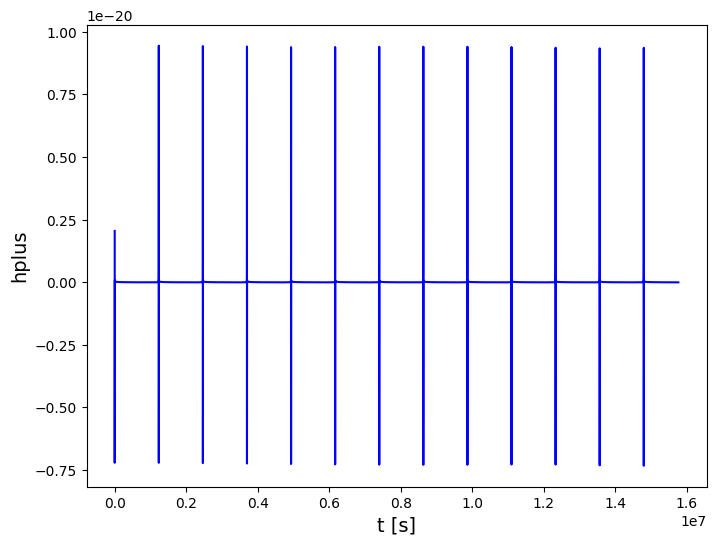

In [4]:
print(f"Generate GW waveform for this example system.")
from Waveform_modeling import PN_waveform
Dl = example_system[1]
a0 = example_system[2]
e0 = example_system[3]
m1 = example_system[4]
m2 = example_system[5]
tobs = 0.5 # assume 0.5 year observation time
theta = pi/4 # assume a GW propagation direction in source frame
phi = pi/4 # assume a GW propagation direction in source frame

M = (m1 + m2)*1.98840987e30 # solar mass in kg
forb = np.sqrt( G * M / (4 * pi * pi * np.power(a0*au, 3.0)))  # orbital frequency

example_waveform = PN_waveform.eccGW_waveform(forb,e0,tobs,m1,m2,theta,phi,Dl,verbose=False)
"""
The returned list has the following columns:
[0] timelist
[1] hpluslist
[2] hcrosslist
"""
timelist = example_waveform[0]
hpluslist = example_waveform[1]
hcrosslist = example_waveform[2]

fig1 = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(timelist, hpluslist, color='BLUE', label='NEW')
plt.xlabel("t [s]", fontsize=14)
plt.ylabel("hplus", fontsize=14)
plt.show()

Generate LISA detector response for this example GW signal.


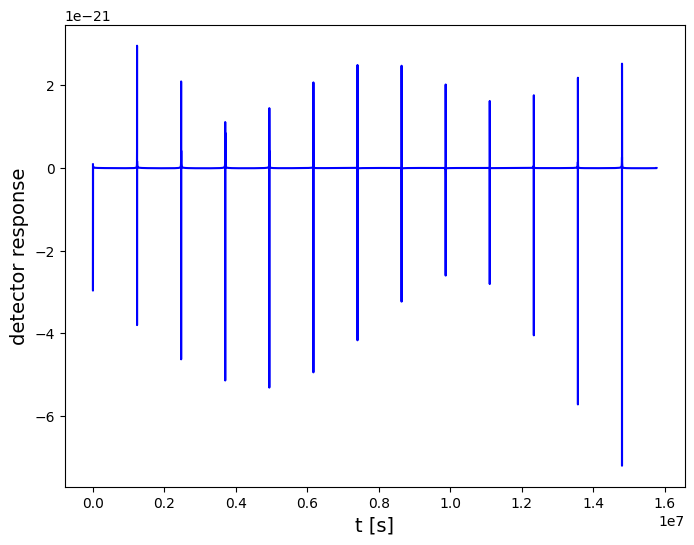

In [5]:
print(f"Generate LISA detector response for this example GW signal.")
theta_sky = pi/4 # assume source location on the sky
phi_sky = pi/4 # assume source location on the sky
psi_sky = pi/4 # assume source polarization direction on the sky

example_response = PN_waveform.compute_LISA_response(timelist,hpluslist,hcrosslist,theta_sky,phi_sky,psi_sky)
"""
The returned list has the following columns:
[0] timelist
[1] responselist
"""
timelist_new = example_response[0]
responselist = example_response[1]
fig2 = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(timelist_new, responselist, color='BLUE', label='NEW')
plt.xlabel("t [s]", fontsize=14)
plt.ylabel("detector response", fontsize=14)
plt.show()


In [9]:
print(f"Estimate sky-averaged SNR for this example system using built-in analytical method.")
SNR_analytical = PN_waveform.SNR(m1,m2,a0,e0,Dl,tobs)
print(f"SNR_analytical = {SNR_analytical} for {tobs} yr")

print(f"Estimate SNR for example GW signal (h_plus) using numerical inner product method.")
fs = 1/(timelist[1]-timelist[0]) # wavefrom sample rate
phase_difference = 0 # no phase difference
innerproduct = PN_waveform.inner_product(fs,hpluslist,hpluslist,phase_difference)
SNR_numerical = np.sqrt(innerproduct)
print(f"SNR_numerical = {SNR_numerical} for {tobs} yr")

Estimate sky-averaged SNR for this example system using built-in analytical method.
SNR_analytical = 42.03976755396774 for 0.5 yr
Estimate SNR for example GW signal (h_plus) using numerical inner product method.
SNR_numerical = 70.04683818803058 for 0.5 yr


In [10]:
print(f"Estimate merger timescale for this example system (Peters equation)")
tmerger=PN_waveform.tmerger_integral(m1,m2,a0,e0)
print(f"T_merger = {tmerger} yrs.")

print(f"Estimate orbital parameters after given time.")
delta_t=tmerger/2
a_new, e_new = PN_waveform.solve_ae_after_time(m1,m2,a0,e0,delta_t)
print(f"After {delta_t} yrs, a_t = {a_new} au, e_t = {e_new}.")

Estimate merger timescale for this example system (Peters equation)
T_merger = 607776.0977413877 yrs.
Estimate orbital parameters after given time.
After 303888.04887069383 yrs, a_t = 0.10052090936150795 au, e_t = 0.9805995400030106.


Compute characteristic strain for example system; Set Tobs = 4.0 yr


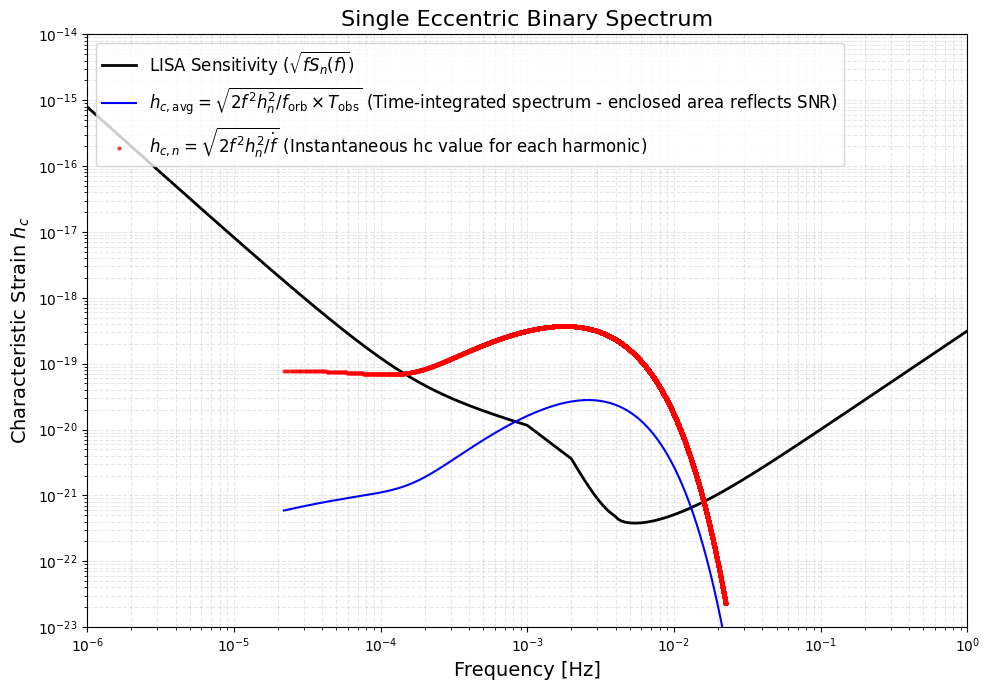

In [11]:
from Waveform_modeling import hc_cal
tobs_new = 4.0
print(f"Compute characteristic strain for example system; Set Tobs = {tobs_new} yr")
test_res = hc_cal.calculate_single_system(m1=m1, m2=m2, a=a0, e=e0, Dl=Dl,tobs_years=tobs)
hc_cal.plot_single_system_results(test_res)

Compute characteristic strain for all the BBHs in the population
Start calculation for 949 systems (Sequential mode)...
Calculation done in 33.68 seconds.


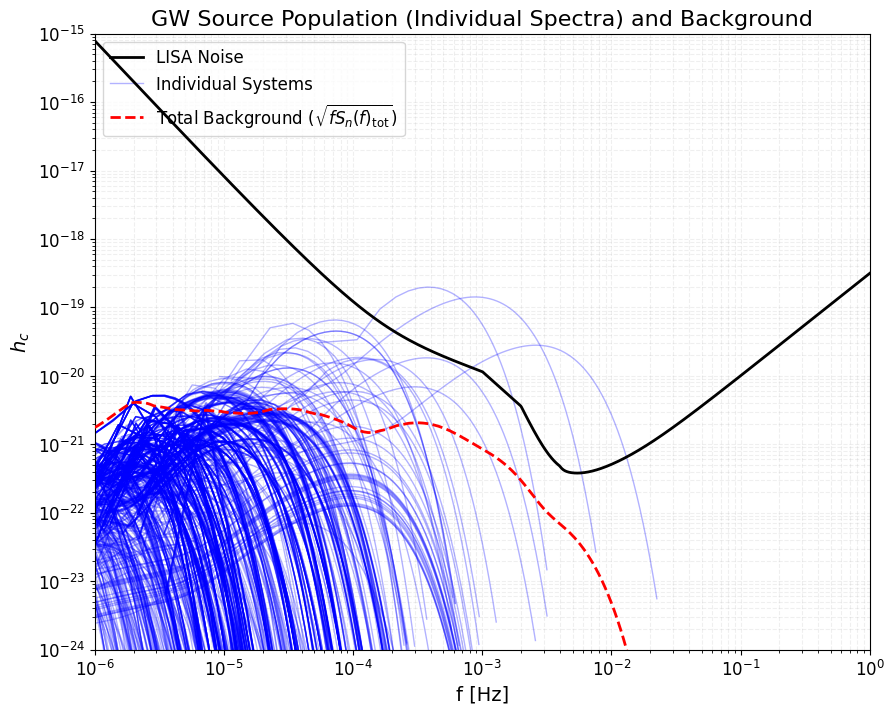

In [12]:
print(f"Compute characteristic strain for all the BBHs in the population")
# return: faxis, Snf, fn_lists, hcavg_lists, hnc_lists
batch_results = hc_cal.process_population_batch(snapshot_data, tobs_years=tobs)

# plot
hc_cal.plot_simulation_results(batch_results)